In [39]:
import jax 
from jax import config
config.update("jax_enable_x64", True)

import jax.numpy as np
from jax import grad, jit, vmap
import jax.scipy as jsp 

import drpangloss
# from drpangloss.oifits_implaneia import load_oifits, cp_indices
from drpangloss.models import BinaryModelAngular, BinaryModelCartesian, OIData

import zodiax as zx
import equinox as eqx
import optimistix as optx 

import pyoifits as oifits

from functools import partial
import matplotlib.pyplot as plt
import matplotlib

In [2]:
fname = "NuHor_F480M.oifits"
ddir = "../data/"

data = oifits.open(ddir+fname)

data.verify('silentfix')


oidata = OIData(data)

In [3]:
true_values = [150., 150., 5e-4] # ra, dec, planet flux
binary = BinaryModelCartesian(true_values[0], true_values[1], true_values[2])

cvis_sim = binary.model(oidata.u, oidata.v, oidata.wavel)

# fill out a new oidata model with simulated values
sim_data = {'u': oidata.u,
            'v': oidata.v,
            'wavel': oidata.wavel,
            'vis': oidata.to_vis(cvis_sim),
            'd_vis': oidata.d_vis,
            'phi': oidata.to_phases(cvis_sim),
            'd_phi': oidata.d_phi,
            'i_cps1': oidata.i_cps1,
            'i_cps2': oidata.i_cps2,
            'i_cps3': oidata.i_cps3,
            'v2_flag': oidata.v2_flag,
            'cp_flag': oidata.cp_flag}

oidata_sim = OIData(sim_data)

In [28]:
def loglike(values, params, data_obj, model_class):
    '''
    Abstract log-likelihood function for a given model class and data object, assuming Gaussian errors.

    Parameters
    ----------
    values : array-like
        Values of the model parameters.
    params : list
        List of parameter names.
    data_obj : OIData
        Object containing the data to be fitted.
    model_class : class
        Model class to be fitted to the data.

    Returns
    -------
    float
        Log-likelihood value.
    '''

    param_dict = dict(zip(params, values))

    model_data = data_obj.model(model_class(**param_dict))
    data, errors = data_obj.flatten_data()

    return -0.5*np.sum((data - model_data)**2/errors**2)

@partial(jit, static_argnames=("model_class"))
def likelihood_grid(data_obj, model_class, samples_dict):
    ''' 
    Function to vmap a likelihood function over a grid of parameter values provided in a dictionary.

    Parameters
    ----------
    data_obj : OIData
        Object containing the data to be fitted.
    model_class : class
        Model class to be fitted to the data.
    samples_dict: dict
        Dictionary of parameter names and values to be fitted to the data.

    Returns
    -------
    array-like
        Log-likelihood values over the grid of parameter values.
    '''
    
    params = list(samples_dict.keys())
    samples = samples_dict.values()
    vals = np.array(np.meshgrid(*samples))
    vals_vec = vals.reshape((len(vals), -1)).T
    
    fn = vmap(lambda values: loglike(values, params, data_obj,model_class))

    return fn(vals_vec).reshape(vals.shape[1:]) # check the shapes output here

In [29]:
params = ["dra", "ddec", "flux"]

loglike(true_values, params, oidata_sim,BinaryModelCartesian,) # once to jit

Array(-0., dtype=float64)

In [30]:
grad(loglike,argnums=0)(np.array(true_values)+np.array([0,1,2]), params, oidata_sim,BinaryModelCartesian) # once to jit

Array([ 4.75679683e+06,  3.29345025e+05, -3.44182810e+08], dtype=float64)

In [31]:
%%timeit 
loglike(true_values, params, oidata_sim,BinaryModelCartesian)

602 µs ± 11.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [111]:
samples_dict = {
    "dra":  np.linspace(600., -600., 100), # left is more RA 
    "ddec": np.linspace(-600., 600., 100), # up is more dec
    "flux": 10**np.linspace(-6, -1, 100)}

loglike_im = likelihood_grid(oidata_sim, BinaryModelCartesian, samples_dict) # calculate once to jit

In [112]:
%%timeit
loglike_im = likelihood_grid(oidata_sim, BinaryModelCartesian, samples_dict)

593 ms ± 36.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


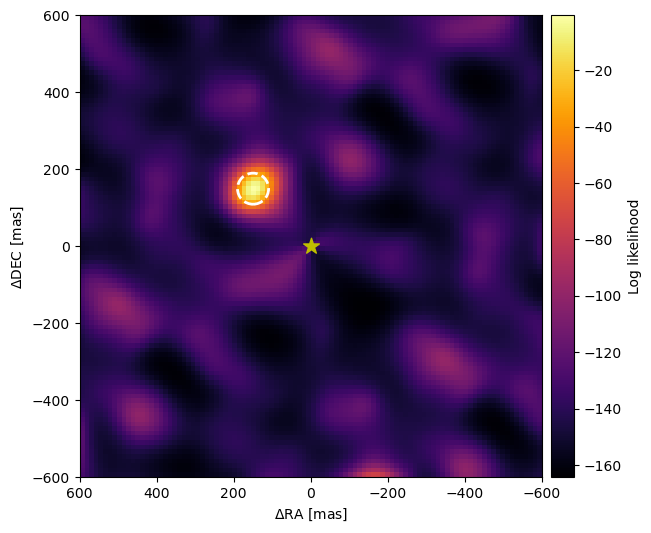

In [113]:
plt.figure(figsize=(12,6))

plt.imshow(loglike_im.max(axis=2).T, cmap="inferno",aspect="equal",
           extent = [samples_dict["dra"].max(), samples_dict["dra"].min(), # this may seem weird, but left is more RA and up is more Dec
                        samples_dict["ddec"].max(), samples_dict["ddec"].min()]) # this took me far too long to get the sign right for
plt.colorbar(shrink=1,label='Log likelihood', pad=0.01)
plt.scatter(0,0,s=140,c='y',marker='*')

plt.xlabel('$\\Delta$RA [mas]')
plt.ylabel('$\\Delta$DEC [mas]')

dra_inp, ddec_inp = true_values[0], true_values[1]
plt.scatter(dra_inp,ddec_inp, 
           s=500,linestyle='--', facecolors='none', edgecolors='white',linewidths=2,alpha=1)
plt.gca().invert_yaxis() # up is more Dec


Function to plot this automatically.

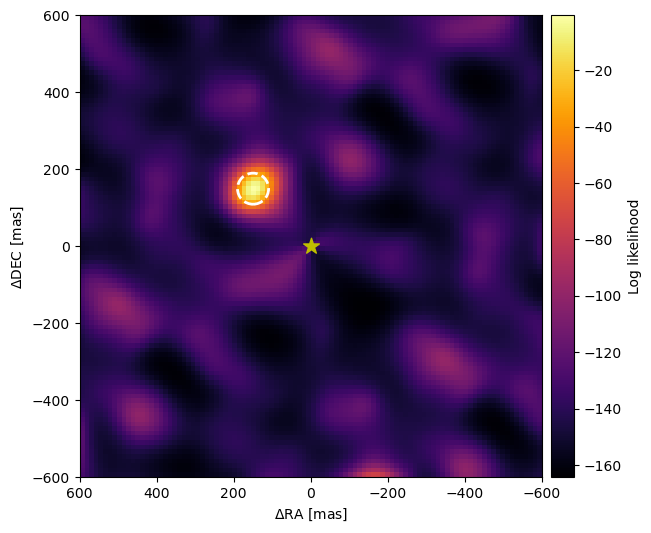

In [114]:
def plot_likelihood_grid(loglike_im, samples_dict,truths=None):
    '''
    Plot the results of a likelihood_grid calculation.

    Parameters
    ----------
    loglike_im : array
        The likelihood grid, output of likelihood_grid
    samples_dict : dict
        Dictionary of samples used in the grid calculation
    truths : list, optional 
        List of true values for the parameters, default None
    '''

    plt.figure(figsize=(12,6))

    plt.imshow(loglike_im.max(axis=2).T, cmap="inferno",aspect="equal",
            extent = [samples_dict["dra"].max(), samples_dict["dra"].min(), # this may seem weird, but left is more RA and up is more Dec
                            samples_dict["ddec"].max(), samples_dict["ddec"].min()]) # this took me far too long to get the sign right for
    plt.colorbar(shrink=1,label='Log likelihood', pad=0.01)
    plt.scatter(0,0,s=140,c='y',marker='*')

    plt.xlabel('$\\Delta$RA [mas]')
    plt.ylabel('$\\Delta$DEC [mas]')

    if truths is not None:
        dra_inp, ddec_inp = truths[0], truths[1]
        plt.scatter(dra_inp,ddec_inp, 
                s=500,linestyle='--', facecolors='none', edgecolors='white',linewidths=2,alpha=1)
    plt.gca().invert_yaxis() # up is more Dec

plot_likelihood_grid(loglike_im, samples_dict, truths=true_values)

Next, let's fit the best likelihood in each pixel by optimization.

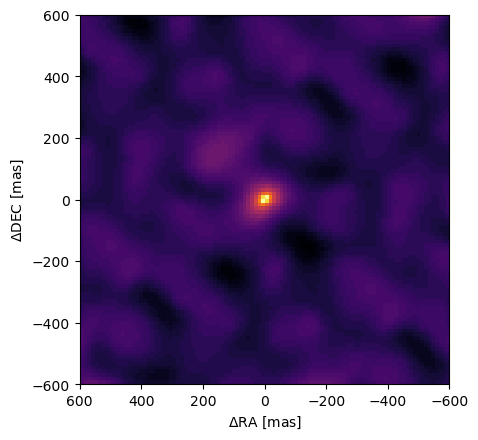

In [134]:
best_contrast_indices = np.argmax(loglike_im,axis=2)
best_contrasts = samples_dict['flux'][best_contrast_indices]
plt.imshow(best_contrasts.T, cmap="inferno",aspect="equal", norm=matplotlib.colors.LogNorm(),
           extent = [samples_dict["dra"].max(), samples_dict["dra"].min(), # this may seem weird, but left is more RA and up is more Dec
                        samples_dict["ddec"].max(), samples_dict["ddec"].min()]) # this took me far too long to get the sign right for
plt.xlabel('$\\Delta$RA [mas]')
plt.ylabel('$\\Delta$DEC [mas]')

plt.gca().invert_yaxis() # up is more Dec

In [124]:
# can we optimize flux from a starting point 

to_optimize = lambda flux, dra_inp, ddec_inp: -loglike([dra_inp, ddec_inp, flux], params, oidata_sim, BinaryModelCartesian)
bestcon = lambda flux, dra, ddec: optx.compat.minimize(to_optimize, x0= np.array([flux]), args=(dra,ddec), 
                        method='BFGS', options={"maxiter":100}).x
res = bestcon(5e-4,150.,150.)
np.log10(res)

Array([-3.30103], dtype=float64)

In [143]:
@partial(jit, static_argnames=("model_class"))
def optimized_contrast_grid(best_contrast_indices, data_obj, model_class, samples_dict):
    '''
    Function to optimize the contrast of a model over a grid of parameter values provided in a dictionary.

    Parameters
    ----------
    best_contrast_indices : array-like
        Indices of the best contrast values in a grid calculated with likelihood_grid.
    data_obj : OIData
        Object containing the data to be fitted.
    model_class : class
        Model class to be fitted to the data.
    samples_dict: dict
        Dictionary of parameter names and values to be fitted to the data.

    Returns
    -------
    array-like
        Optimized contrast values over the grid of parameter values.

    '''
    
    params = list(samples_dict.keys())
    coords = [samples_dict[key] for key in ["dra", "ddec"]]
    ras, decs = np.meshgrid(*coords)
    vals = np.array([samples_dict['flux'][best_contrast_indices], ras, decs])
    vals_vec = vals.reshape((len(vals), -1)).T

    to_optimize = lambda flux, dra_inp, ddec_inp: -loglike([dra_inp, ddec_inp, flux], params, data_obj, model_class)
    bestcon = lambda flux, dra, ddec: optx.compat.minimize(to_optimize, x0= np.array([flux]), args=(np.array(dra),np.array(ddec)), 
                            method='BFGS', options={"maxiter":100}).x

    fn = vmap(lambda values: bestcon(*values))

    return fn(vals_vec).reshape(vals.shape[1:]) # check the shapes output here

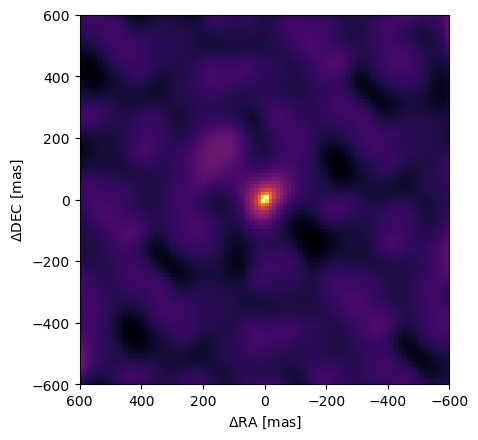

In [144]:
optimized = optimized_contrast_grid(best_contrast_indices, oidata_sim, BinaryModelCartesian, samples_dict)

plt.imshow(optimized, cmap="inferno",aspect="equal", norm=matplotlib.colors.LogNorm(),
           extent = [samples_dict["dra"].max(), samples_dict["dra"].min(), # this may seem weird, but left is more RA and up is more Dec
                        samples_dict["ddec"].max(), samples_dict["ddec"].min()]) # this took me far too long to get the sign right for
plt.xlabel('$\\Delta$RA [mas]')
plt.ylabel('$\\Delta$DEC [mas]')

plt.gca().invert_yaxis() # up is more Dec

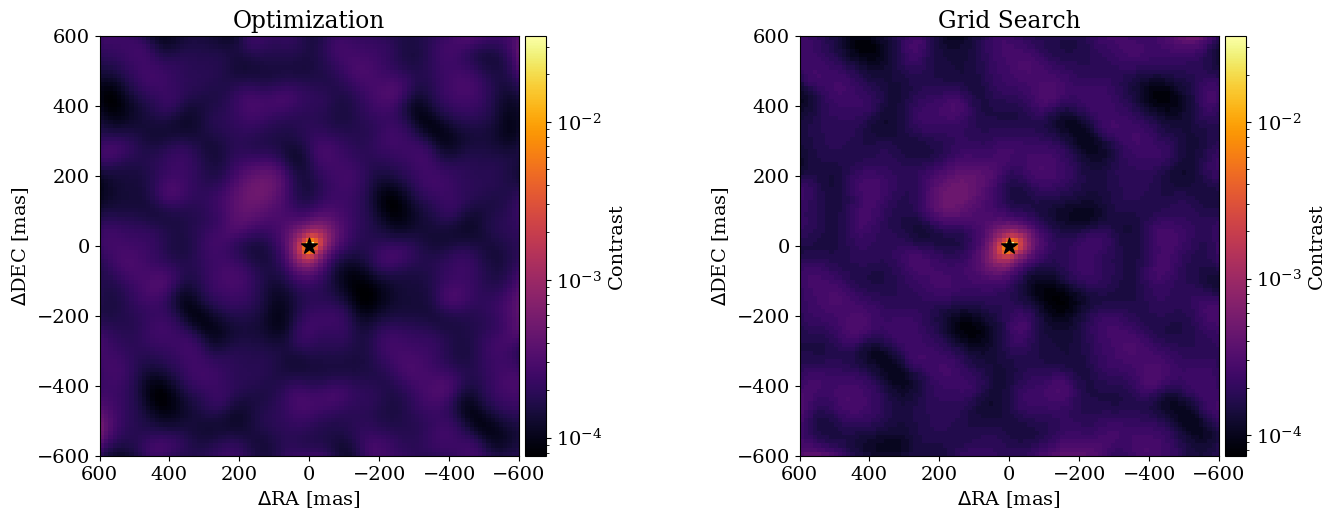

In [149]:
def plot_optimized_and_grid(loglike_im, optimized, samples_dict):

    best_contrast_indices = np.argmax(loglike_im,axis=2)
    best_contrasts = samples_dict['flux'][best_contrast_indices]

    plt.figure(figsize=(14,5))
    matplotlib.rcParams['figure.dpi'] = 100
    matplotlib.rcParams['font.family'] = ['serif']
    plt.rcParams.update({'font.size': 14})
    plt.subplot(1,2,1)
    plt.imshow(optimized,cmap='inferno', norm = matplotlib.colors.LogNorm(),
                        extent = [samples_dict["dra"].max(), samples_dict["dra"].min(), # this may seem weird, but left is more RA and up is more Dec
                        samples_dict["ddec"].max(), samples_dict["ddec"].min()]) # this took me far too long to get the sign right for
    plt.colorbar(shrink=1,label='Contrast', pad=0.01)
    plt.scatter(0,0,s=140,c='black',marker='*')
    plt.xlabel('$\\Delta$RA [mas]')
    plt.ylabel('$\\Delta$DEC [mas]')
    plt.title('Optimization')
    plt.gca().invert_yaxis()

    plt.subplot(1,2,2)
    plt.imshow(best_contrasts.T,cmap='inferno', norm = matplotlib.colors.LogNorm(),
                            extent = [samples_dict["dra"].max(), samples_dict["dra"].min(), # this may seem weird, but left is more RA and up is more Dec
                            samples_dict["ddec"].max(), samples_dict["ddec"].min()]) # this took me far too long to get the sign right for
    plt.colorbar(shrink=1,label='Contrast', pad=0.01)
    plt.scatter(0,0,s=140,c='black',marker='*')
    plt.xlabel('$\\Delta$RA [mas]')
    plt.ylabel('$\\Delta$DEC [mas]')
    plt.title('Grid Search')
    plt.gca().invert_yaxis()
    plt.tight_layout(pad=0.)
    plt.show()

plot_optimized_and_grid(loglike_im, optimized, samples_dict)

## Now let's calculate uncertainties by the Laplace method.

In [170]:
def laplace_cov(values, params, data_obj, model_class):

    '''
    Calculate the uncertainty with the Laplace method from an optimized fit between a model and data object.

    Parameters
    ----------
    Parameters
    ----------
    values : array-like
        Values of the model parameters.
    params : list
        List of parameter names.
    data_obj : OIData
        Object containing the data to be fitted.
    model_class : class
        Model class to be fitted to the data.

    Returns
    -------
    array-like
        Covariance matrix.
    '''

    hess = jax.hessian(loglike, argnums=0)(values, params, data_obj, model_class)
    return -np.linalg.inv(np.array(hess))

laplace_cov(true_values, params, oidata_sim, BinaryModelCartesian)

def laplace_contrast_uncertainty(flux, dra, ddec, data_obj, model_class):

    '''
    Calculate the uncertainty with the Laplace method from an optimized fit between a model and data object.

    Parameters
    ----------
    Parameters
    ----------
    values : array-like
        Values of the model parameters.
    params : list
        List of parameter names.
    data_obj : OIData
        Object containing the data to be fitted.
    model_class : class
        Model class to be fitted to the data.

    Returns
    -------
    array-like
        Uncertainty in the contrast.
    '''

    objective = lambda flux: -loglike([dra, ddec, flux], params, data_obj, model_class)
    hess = jax.hessian(objective)(flux)
    cov = 1/(np.array(hess))
    return np.sqrt(cov)

laplace_contrast_uncertainty(5e-4, 150., 150., oidata_sim, BinaryModelCartesian)

Array(2.72655191e-05, dtype=float64, weak_type=True)

In [171]:
@partial(jit, static_argnames=("model_class"))
def laplace_contrast_uncertainty_grid(best_contrast_indices, data_obj, model_class, samples_dict):
    '''
    Calculate the uncertainty with the Laplace method over a grid of parameters, for an optimized fit between a model and data object.

    Parameters
    ----------
    best_contrast_indices : array-like
        Indices of the best contrast values in a grid calculated with likelihood_grid.
    data_obj : OIData
        Object containing the data to be fitted.
    model_class : class
        Model class to be fitted to the data.
    samples_dict: dict
        Dictionary of parameter names and values to be fitted to the data.

    Returns
    -------
    array-like
        Uncertainty in the contrast.
    '''

    params = list(samples_dict.keys())
    coords = [samples_dict[key] for key in ["dra", "ddec"]]
    ras, decs = np.meshgrid(*coords)
    vals = np.array([samples_dict['flux'][best_contrast_indices], ras, decs])
    vals_vec = vals.reshape((len(vals), -1)).T

    
    sigma = lambda flux, dra, ddec: laplace_contrast_uncertainty(flux, dra, ddec, data_obj, model_class)
    fn = vmap(lambda values: sigma(*values))

    return fn(vals_vec).reshape(vals.shape[1:]) # check the shapes output here

laplace_sigma_grid = laplace_contrast_uncertainty_grid(best_contrast_indices, oidata_sim, BinaryModelCartesian, samples_dict)


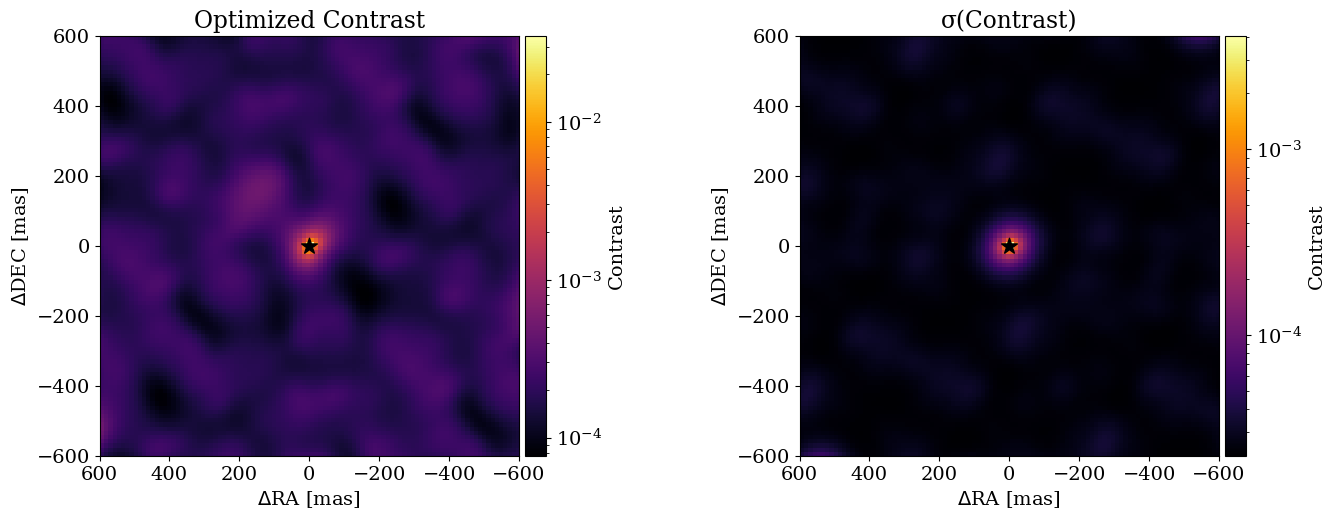

In [173]:
def plot_optimized_and_sigma(optimized, sigma_grid, samples_dict):

    plt.figure(figsize=(14,5))
    matplotlib.rcParams['figure.dpi'] = 100
    matplotlib.rcParams['font.family'] = ['serif']
    plt.rcParams.update({'font.size': 14})
    plt.subplot(1,2,1)
    plt.imshow(optimized,cmap='inferno', norm = matplotlib.colors.LogNorm(),
                        extent = [samples_dict["dra"].max(), samples_dict["dra"].min(), # this may seem weird, but left is more RA and up is more Dec
                        samples_dict["ddec"].max(), samples_dict["ddec"].min()]) # this took me far too long to get the sign right for
    plt.colorbar(shrink=1,label='Contrast', pad=0.01)
    plt.scatter(0,0,s=140,c='black',marker='*')
    plt.xlabel('$\\Delta$RA [mas]')
    plt.ylabel('$\\Delta$DEC [mas]')
    plt.title('Optimized Contrast')
    plt.gca().invert_yaxis()

    plt.subplot(1,2,2)
    plt.imshow(sigma_grid,cmap='inferno', norm = matplotlib.colors.LogNorm(),
                            extent = [samples_dict["dra"].max(), samples_dict["dra"].min(), # this may seem weird, but left is more RA and up is more Dec
                            samples_dict["ddec"].max(), samples_dict["ddec"].min()]) # this took me far too long to get the sign right for
    plt.colorbar(shrink=1,label='Contrast', pad=0.01)
    plt.scatter(0,0,s=140,c='black',marker='*')
    plt.xlabel('$\\Delta$RA [mas]')
    plt.ylabel('$\\Delta$DEC [mas]')
    plt.title('σ(Contrast)')
    plt.gca().invert_yaxis()
    plt.tight_layout(pad=0.)
    plt.show()

plot_optimized_and_sigma(optimized, laplace_sigma_grid, samples_dict)